In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pylab import mpl
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from scipy import optimize

In [2]:
#Cluster directories:
M35_dir = 'M35'
M67_dir = 'M67'
M67v2_dir = 'M67v2'
NGC869_dir = 'NGC869'

#Setting Cluster to process
cluster_dir = M67_dir  #------------------------------------------!!!!!

#Output directories to shared and local folders
shared_dir = os.path.join('/data/observatory/student_data/William_ODonnell', cluster_dir)
calib_dir = 'Magnitude_Calibration_Files'
local_dir = cluster_dir

In [3]:
cal = (pd.read_csv(os.path.join(calib_dir, cluster_dir + '_Calibration_Star_List.csv'))).values
cal_RA = cal[:,1]
cal_DEC = cal[:,2]
cal_Gmag = cal[:,4]
cal_Imag = cal[:,6]
cal_Rmag = cal[:,5]

cal_arr = np.vstack((cal_RA, cal_DEC, cal_Gmag, cal_Imag, cal_Rmag)).T

cal_df = pd.DataFrame(cal_arr, columns = ['Right-Ascension', 'Declination', 'G_Mag','I_Mag', 'R_Mag'], dtype = float)
cal_df = cal_df.round({'Right-Ascension': 3, 'Declination': 3, 'G_Mag':3, 'R_Mag':3, 'I_Mag':3})
cal_df = cal_df.drop_duplicates(subset = ['Right-Ascension' , 'Declination'], keep = 'first')
cal_df = cal_df.sort_values(by = ['Right-Ascension', 'Declination'], ascending = False)

mags = (pd.read_csv(os.path.join(local_dir, "3. " + cluster_dir + '_Uncalibrated_mags.csv'))).values
mags_ID = mags[:,1]
mags_RA = mags[:,2]
mags_DEC = mags[:,3]
mags_Gmag = mags[:,4]
mags_Imag = mags[:,5]
mags_Rmag = mags[:,6]
mags_arr = np.vstack((mags_RA, mags_DEC, mags_Gmag, mags_Imag, mags_Rmag)).T

all_data = np.concatenate((mags_arr, cal_df.values))
all_df = pd.DataFrame(all_data, columns = ['Right-Ascension', 'Declination', 'G_Mag','I_Mag', 'R_Mag'], dtype = float)
all_df = all_df.sort_values(by = ['Right-Ascension', 'Declination'], ascending = False)
all_df = all_df.round({'Right-Ascension': 3, 'Declination': 3})
all_df = all_df.dropna()


#Perform sort for 2 consecutive dupes and remove and add to new df as from before.
All_Match = all_df.duplicated(subset = ['Right-Ascension', 'Declination'], keep = False)

#Adding duplicates to separate array - to filter out non-matches
Matches = []
n = 0
for line in All_Match.values:
    if line == True:
        #print(Full_data[n])
        Matches.append(all_df.values[n])
        n = n+1
    if line == False:
        n = n+1

        
matches_df = pd.DataFrame(Matches, columns = ['Right-Ascension', 'Declination', 'G_Mag','I_Mag', 'R_Mag'], dtype = np.float64)
matches_df = matches_df.sort_values(by = ['Right-Ascension', 'Declination', 'G_Mag'], ascending = True)

match = matches_df.values

data_RA = []
data_DEC = []
data_Gband = []
data_Iband = []
data_Rband = []

cali_RA = []
cali_DEC = []
cali_Gband = []
cali_Iband = []
cali_Rband = []

z = 0
n = 0

while z < len(match):
    if match[z][0] == match[z+1][0] and match[z][1] == match[z+1][1]:
        data_Gband.append(match[z][2])
        data_Iband.append(match[z][3])
        data_Rband.append(match[z][4])
    
        cali_Gband.append(match[z+1][2])
        cali_Iband.append(match[z+1][3])
        cali_Rband.append(match[z+1][4])
        
        z = z + 2
        n= n+1

0.9925653605882395 0.005816795131991767
-18.430972717528544 0.07787075985742187


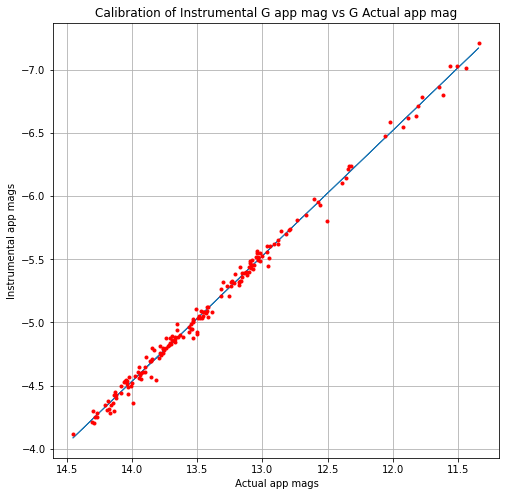

In [4]:
def linear(x, m, c):
    return m*x + c

G_P, G_V = optimize.curve_fit(linear, cali_Gband, data_Gband, p0=[1, 0])
G_fit = np.polyval(G_P, cali_Gband)

def Gmag(data):
    return (data - G_P[1])/G_P[0]

G_grad_err = np.sqrt(G_V[0][0]) #s.d.
G_interc_err = np.sqrt(G_V[1][1]) #s.d.
G_calib_err = Gmag(mags_Gmag) * np.sqrt((G_grad_err/G_P[0])**2 + (G_interc_err/G_P[1])**2)

plt.figure(figsize=(8, 8))
plt.plot(cali_Gband, G_fit, linewidth = 1, label = "Best Fit Line")
plt.plot(cali_Gband, data_Gband, ".", color = "Red")
plt.xlabel(" Actual app mags")
plt.ylabel("Instrumental app mags")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("Calibration of Instrumental G app mag vs G Actual app mag")
plt.grid()
plt.plot()

print(G_P[0], G_grad_err)
print(G_P[1], G_interc_err)

0.9877531286080663 +/- 0.005580970646985563
-16.72134220746283 +/- 0.07157836027056456


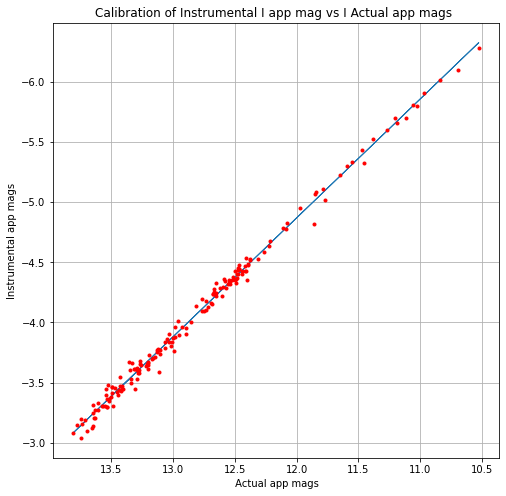

In [5]:
I_P, I_V = optimize.curve_fit(linear, cali_Iband, data_Iband, p0=[1, 0])
I_fit = np.polyval(I_P, cali_Iband)

def Imag(data):
    return (data - I_P[1])/I_P[0]

I_grad_err = np.sqrt(I_V[0][0])
I_interc_err = np.sqrt(I_V[1][1])
I_calib_err = Imag(mags_Imag) * np.sqrt((I_grad_err/I_P[0])**2 + (I_interc_err/I_P[1])**2)

plt.figure(figsize=(8, 8))
plt.plot(cali_Iband, I_fit, linewidth = 1, label = "Best Fit Line")
plt.plot(cali_Iband, data_Iband, ".", color = "Red")
plt.xlabel(" Actual app mags")
plt.ylabel("Instrumental app mags")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("Calibration of Instrumental I app mag vs I Actual app mags ")
plt.grid()
plt.plot()

print(I_P[0], '+/-',I_grad_err)
print(I_P[1], '+/-',I_interc_err)

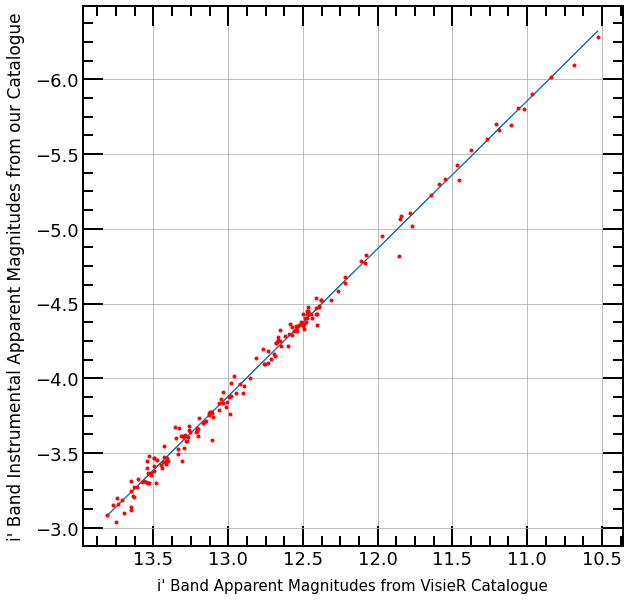

In [8]:
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes([0.1,0.1,0.75,0.75])

ax.plot(cali_Iband, I_fit, linewidth = 1, label = "Best Fit Line")
ax.plot(cali_Iband, data_Iband, ".", color = "Red")
# plt.xlim(left = 10.5)
# plt.xlim(right = 13.999)
# plt.ylim(top = -4.5)
# plt.ylim(bottom = -8.0)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.grid()

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.125))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.125))
plt.tick_params(which='major', size=20, width=2, direction='in', top='on')
plt.tick_params(which='minor', size=10, width=2, direction='in', top='on')
plt.tick_params(which='major', size=20, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=10, width=2, direction='in', right='on')

plt.xlabel("i' Band Apparent Magnitudes from VisieR Catalogue", labelpad = 10, fontsize = 15)
plt.ylabel("i' Band Instrumental Apparent Magnitudes from our Catalogue", labelpad = 10, fontsize = 17)
#plt.title(cluster_name + " " + "Colour-Magnitude Diagram", pad = 10, fontsize = 25)

plt.savefig(os.path.join(local_dir, "4. " + cluster_dir +  "_i'_band_Calibration_Plot.pdf"), bbox_inches = 'tight', pad_inches = 0)

0.9979664255620705 +/- 0.0052940518972771945
-17.35813704213147 +/- 0.06815434166620984


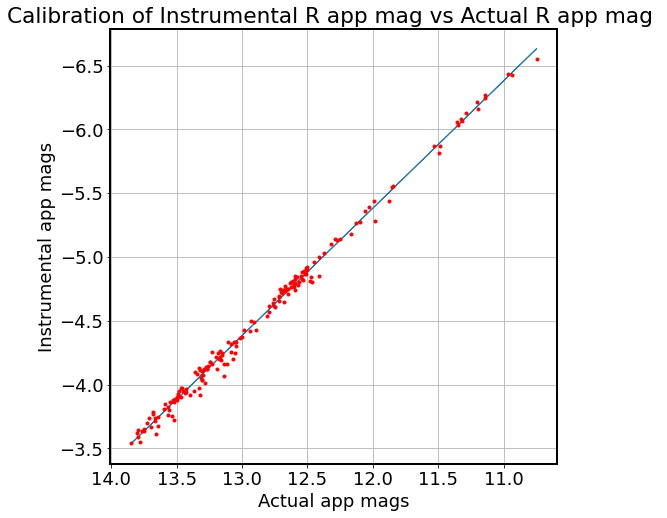

In [8]:
R_P, R_V = optimize.curve_fit(linear, cali_Rband, data_Rband, p0=[1, 0])
R_fit = np.polyval(R_P, cali_Rband)

def Rmag(data):
    return (data - R_P[1])/R_P[0]

R_grad_err = np.sqrt(R_V[0][0])
R_interc_err = np.sqrt(R_V[1][1])
R_calib_err = Rmag(mags_Rmag) * np.sqrt((R_grad_err/R_P[0])**2 + (R_interc_err/R_P[1])**2)

plt.figure(figsize=(8, 8))
plt.plot(cali_Rband, R_fit, linewidth = 1, label = "Best Fit Line")
plt.plot(cali_Rband, data_Rband, ".", color = "Red")
plt.xlabel("Actual app mags")
plt.ylabel("Instrumental app mags")
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("Calibration of Instrumental R app mag vs Actual R app mag ")
plt.grid()
plt.plot()

print(R_P[0], '+/-',R_grad_err)
print(R_P[1], '+/-',R_interc_err)

In [7]:
Corrected = np.vstack((mags_ID, mags_RA, mags_DEC, Gmag(mags_Gmag), G_calib_err, Imag(mags_Imag), I_calib_err, Rmag(mags_Rmag), R_calib_err)).T
Corrected_df = pd.DataFrame(Corrected, columns = ['ID','Right-Ascension', 'Declination', 'G_Mag', 'G_Mag_err','I_Mag', 'I_Mag_err','R_Mag', 'R_Mag_err'])
Corrected_df = Corrected_df.sort_values(by = ['Right-Ascension', 'Declination'], ascending = False)
Corrected_df = Corrected_df.round({'Right-Ascension': 3, 'Declination': 3})
Corrected_df.to_csv(os.path.join(local_dir, "4. " + cluster_dir + "_Final_Corrected_Mags.csv"))